We reverse engineer the L26H9 head on don't say prompts.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens

from pii import ablation, prompt_data, utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [4]:
# def get_dontsay_prompt(question: str, forbidden_word: str):
#     return f"""\
# [INST] <<SYS>>
# You are an obedient assistant who only responds with a single word. \
# You are not allowed to say the forbidden word {forbidden_word}. \
# <</SYS>>
# I'm going to ask you a sport question. Some example sports are baseball and tennis. \
# {question} [/INST] \
# """

def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""

# question = "The protagonist of Half Life is"
# forbidden_words = ["apple", "Gordon"]
question = "Tom Brady plays the sport of"
forbidden_words = ["apple", "football"]
# question = "The Eiffel Tower is located in"
# forbidden_words = ["apple", "Paris"]
# question = "The element with atomic symbol H is"
# forbidden_words = ["apple", "hydrogen"]

# question = "An example of a red and crunchy fruit is a"
# forbidden_words = ["football", "apple"]

tl_model.remove_all_hook_fns(including_permanent=True)
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
        n_continuation_tokens=10,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 26.48 Prob: 99.67% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 20.00 Prob:  0.15% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 2. Logit: 19.85 Prob:  0.13% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.54 Prob:  0.01% Tokens: (13440) |Foot|ball|</s>|
Rank 4. Logit: 17.15 Prob:  0.01% Tokens: (25167) |NFL|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.79 Prob: 63.15% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 16.07 Prob: 11.32% Tokens: (21850) |Basketball|</s>|
Rank 2. Logit: 15.47 Prob:  6.22% Tokens: (  376) |"|B|asketball|"|</s>|
Rank 3. Logit: 15.30 Prob:  5.27% Tokens: (18585) |Sure|!|Tom|Br|ady|plays|...|(|p|aus|es|
Ran

### Cache activations

In [5]:
pd_nc = prompt_data.PromptData.get_data(get_dontsay_prompt(question, forbidden_words[0]), tl_model)
pd_c = prompt_data.PromptData.get_data(get_dontsay_prompt(question, forbidden_words[1]), tl_model)

### Do patching

In [27]:
ld_c_0 = prompt_data.get_ablated_logits(pd=pd_c, tl_model=tl_model)
ld_nc_0 = prompt_data.get_ablated_logits(pd=pd_nc, tl_model=tl_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
ld_nc_c = prompt_data.get_ablated_logits(
    pd=pd_nc,
    tl_model=tl_model,
    ablation_cache=pd_c.cache,
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
ld_c_nc = prompt_data.get_ablated_logits(
    pd=pd_c,
    tl_model=tl_model,
    ablation_cache=pd_nc.cache,
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [28]:
for ld, title in [
    (ld_nc_0, "base: non-competing; patch: zero"),
    (ld_c_0, "base: competing; patch: zero"),
    (ld_nc_c, "base: non-competing; patch: competing"),
    (ld_c_nc, "base: competing; patch: non-competing"),
]:
    orig_logits = ld.pd.final_logits
    logits, labels = ld.get_logits_and_labels()

    orig_log_odds = orig_logits.softmax(dim=-1).logit()
    orig_log_odds_diff = (
        orig_logits[pd_nc.ml_token] - orig_logits[pd_c.ml_token]
    )
    log_odds = logits.softmax(dim=-1).logit()

    utils.plot_head_data(
        lines=[
            (
                f"|{pd_nc.ml_str}|",
                (log_odds - orig_log_odds)[:, pd_nc.ml_token] / np.log(10),
                labels,
            ),
            (
                f"|{pd_c.ml_str}|",
                (log_odds - orig_log_odds)[:, pd_c.ml_token] / np.log(10),
                labels,
            ),
        ],
        annotation_text=ld.pd.prompt.split("\n")[-1],
        title=title
        + f"\n(|{pd_nc.ml_str}| vs |{pd_c.ml_str}| log10 odds = {orig_log_odds_diff / np.log(10):.4f})",
        yaxis_title="Log_10 Bayes Factor\n(change in log odds after patching)",
        xaxis_title="Components",
        height=420,
        width=800,
    ).show()

In [26]:
ld, title = (ld_nc_c, "base: non-competing; patch: competing")
df = ld.get_cumulative_ablations(
    tl_model=tl_model,
    target_token=pd_nc.ml_token,
    top_k=10,
    increasing=True,
)

utils.plot_head_data(
    lines=[
        (f"true", df.log_odds / np.log(10), df.label),
        (f"pred", df.pred_log_odds / np.log(10), df.label),
    ],
    spacing=1,
    annotation_text=ld.pd.prompt.split("\n")[-1],
    title=title,
    yaxis_title=f"Log_10 Odds ({df.token_str[0]})",
    xaxis_title="Ablated Components (cumulative)",
    height=420,
    width=800,
).show()

  0%|          | 0/11 [00:00<?, ?it/s]

### Studying weird asymmetry of L25H12ATN patching

In [56]:
final_logits = ablation.run_with_ablation(
    tl_model=tl_model,
    prompt=pd_nc.prompt,
    ablation_cache=pd_c.cache,
    return_type="logits",
    attn_head_locs=[
        # (25, 12, -1),
        (26, 9, -1),
    ],
    mlp_head_locs=[
        # (31, -1),
    ],
)[0, -1]

orig_log_odds = torch.logit(torch.tensor(pd_nc.ml_prob)).item()
ablt_log_odds = final_logits.softmax(dim=-1)[pd_nc.ml_token].logit().item()

print(f"Orig    log10 odds of {pd_nc.ml_str}:", orig_log_odds / np.log(10))
print(f"Ablated log10 odds of {pd_nc.ml_str}:", ablt_log_odds / np.log(10))

Orig    log10 odds of Football: 2.4832084283298066
Ablated log10 odds of Football: 2.1495095114656024


# Begin reverse engineering of L26H9

In [14]:
ld = ld
cache = ld.pd.cache
if "blocks.0.attn.hook_result" not in cache.cache_dict:
    cache.compute_head_results()

wtok = ld.pd.ml_token
ftok = tl_model.to_single_token("Paris")
fpos = 35
assert ld.pd.tokens[fpos].item() == ftok

wtok_str = tl_model.to_string(wtok)
ftok_str = tl_model.to_string(ftok)

LAYER = 26
HEAD = 9
HEAD_STR = f"L{LAYER}H{HEAD}"
ATTN_SCALE = tl_model.blocks[LAYER].attn.attn_scale

print("Wrong token:", f"|{wtok_str}|", wtok)
print("Forbidden token:", f"|{ftok_str}|", ftok)
print("Attention scale:", f"{ATTN_SCALE:.4f}")

Wrong token: |Nice| 20103
Forbidden token: |Paris| 3681
Attention scale: 11.3137


### Attention pattern on L26H9

In [15]:
pattern = cache["pattern", LAYER][HEAD]
print(f"{HEAD_STR} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

L26H9 Attention Pattern:


### What does the head downweight / upweight (per ablation)?

Tokens most downweighted by L26H9
Paris (-1.111) París (-0.745) anes (-0.723) options (-0.702) eros (-0.658) 
processing (-0.655) Perry (-0.635) Parker (-0.628) yed (-0.605) pleasure (-0.604) 
pity (-0.600) transition (-0.586) options (-0.582) parents (-0.581) Parliament (-0.580) 
Congress (-0.571) Пари (-0.566) Girl (-0.560) hero (-0.558) рес (-0.558) 
Carlos (-0.556) P (-0.545) lop (-0.545) Pérez (-0.540) mez (-0.539) 
Parlament (-0.539) urus (-0.537) � (-0.532) aes (-0.531) possibilities (-0.530) 
uez (-0.529) Roberts (-0.525) processes (-0.523) parse (-0.521) yes (-0.519) 
rez (-0.519) eurs (-0.513) crisis (-0.512) Bitte (-0.512) pandas (-0.511) 
pace (-0.508) ques (-0.507) parallel (-0.504) Options (-0.502) CESS (-0.501) 
processing (-0.497) ulas (-0.497) notes (-0.495) tait (-0.493) ress (-0.493) 
pleasant (-0.491) istent (-0.491) girls (-0.491) payment (-0.490) etro (-0.487) 
status (-0.486) UI (-0.482) girl (-0.480) persistence (-0.479) parliament (-0.478) 
please (-0.478) prac

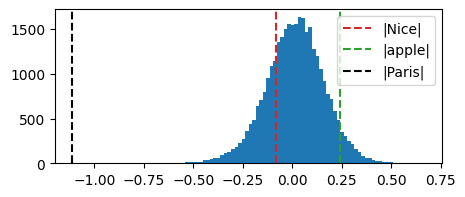

In [16]:
orig_logits = ld.pd.final_logits
logits = ld.attn_head_logits[LAYER][HEAD]

orig_log_odds = orig_logits.softmax(dim=-1).logit()
log_odds = logits.softmax(dim=-1).logit()

log10_bf = (orig_log_odds - log_odds) / np.log(10)

print(f"Tokens most downweighted by {HEAD_STR}")
top_tokens = torch.topk(-log10_bf, 100).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_bf[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

print()
print(f"Tokens most upweighted by {HEAD_STR}")
top_tokens = torch.topk(log10_bf, 10).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_bf[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_bf.cpu().numpy(), bins=100)
plt.axvline(
    log10_bf[wtok].item(),
    color="tab:red",
    linestyle="--",
    label=f"|{wtok_str}|",
)
plt.axvline(
    log10_bf[tl_model.to_single_token("apple")].item(),
    color="tab:green",
    linestyle="--",
    label=f"|apple|",
)
plt.axvline(
    log10_bf[ftok].item(),
    color="black",
    linestyle="--",
    label=f"|{ftok_str}|",
)
plt.legend()
plt.show()

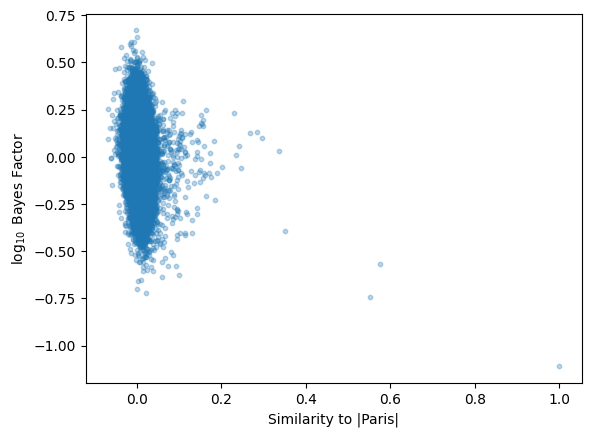

In [55]:
mat = (tl_model.ln_final.w[:, None] * tl_model.W_U).T
# mat = tl_model.W_U.T
# mat = tl_model.W_E
norms = mat.norm(dim=-1, keepdim=True)
unembed_mat = mat / norms

ftok_sims = unembed_mat @ unembed_mat[ftok]
plt.scatter(
    ftok_sims.cpu().numpy(),
    log10_bf.cpu().numpy(),
    s=10,
    alpha=0.3,
)
# plt.xscale("symlog", linthresh=1e-4)
plt.xlabel(f"Similarity to |{ftok_str}|")
plt.ylabel("$\log_{10}$ Bayes Factor")
plt.show()

### OV circuit behavior on forbidden token

In [112]:
E_f = tl_model.W_E[ftok]
U_f = tl_model.W_U[:, ftok]
vs = cache["v", LAYER][:, HEAD]
attn_pattern = cache["pattern", LAYER][HEAD, -1]
result = cache["result", LAYER][-1, HEAD]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[LAYER].ln1
W_V = tl_model.W_V[LAYER, HEAD]
b_V = tl_model.b_V[LAYER, HEAD]
W_O = tl_model.W_O[LAYER, HEAD]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_log10_prob(x):
    return (ln_final(x) @ tl_model.W_U).log_softmax(dim=-1)[ftok] / np.log(10)


print(f"pattern[fpos] = {attn_pattern[fpos]:.3f}")
print()
print(f"{HEAD_STR} stats:")
print_stat("f_log10_prob(result)", f_log10_prob(result))
print_stat(
    "f_log10_odds(pattern @ vs @ W_O)",
    f_log10_prob(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)",
    f_log10_prob(attn_pattern[fpos] * vs[fpos] @ W_O),
)
print()
print_stat(
    "f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_log10_prob(attn_pattern[fpos] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_log10_prob(attn_pattern[fpos] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]",
    (attn_pattern[fpos] * E_f @ W_V @ W_O @ tl_model.W_U).log_softmax(dim=-1)[
        ftok
    ]
    / np.log(10),
)
print_stat("log10(1 / d_vocab)", np.log10(1 / tl_model.cfg.d_vocab))

pattern[fpos] = 0.593

L27H29 stats:
f_log10_prob(result)                                            : -19.416090
f_log10_odds(pattern @ vs @ W_O)                                : -19.416092
f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)                    : -19.370003

f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)          : -16.470989
f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)               : -16.108114

softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]    : -4.530059
log10(1 / d_vocab)                                              : -4.505150


### OV circuit behavior on embedding vectors

tensor(-16.3600, device='cuda:0')
Tokens L27H29 most downweights from raw embedding
China (-24.895) Trump (-22.274) Jordan (-21.829) Washington (-20.685) Amazon (-20.571) 
police (-20.303) monitor (-20.248) techn (-20.246) dynamic (-20.217) Anna (-20.193) 
Apple (-20.116) Bush (-20.090) Chinese (-20.013) Gu (-19.957) George (-19.930) 
Bar (-19.919) DC (-19.894) Technology (-19.880) Science (-19.834) Ford (-19.764) 
Hamilton (-19.720) technology (-19.699) Techn (-19.668) science (-19.627) Jacob (-19.606) 
Indian (-19.590) German (-19.522) Christ (-19.518) MC (-19.480) Jesus (-19.383) 
DJ (-19.363) FM (-19.270) magic (-19.257) Kate (-19.233) Hub (-19.178) 
Facebook (-19.093) God (-19.077) Jord (-19.061) Disney (-19.059) Lincoln (-19.054) 
ABC (-18.883) Microsoft (-18.835) Magic (-18.814) Martin (-18.758) Nelson (-18.741) 
Gu (-18.702) Moon (-18.695) monitoring (-18.680) HD (-18.672) Jones (-18.665) 


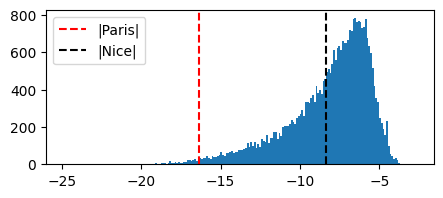

In [113]:
# Very big, 32k x 32k
log10_resp_mat = (
    ln_final(tl_model.W_E @ W_V @ W_O) @ tl_model.W_U
).log_softmax(dim=-1) / np.log(10)

print(log10_resp_mat[ftok, ftok])
print(f"Tokens {HEAD_STR} most downweights from raw embedding")
top_tokens = torch.topk(-log10_resp_mat.diag(), 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_resp_mat.diag()[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_resp_mat.diag().cpu().numpy(), bins=200)
plt.axvline(
    log10_resp_mat[ftok, ftok].item(),
    color="red",
    linestyle="--",
    label=f"|{ftok_str}|",
)
plt.axvline(
    log10_resp_mat[wtok, wtok].item(),
    color="black",
    linestyle="--",
    label=f"|{wtok_str}|",
)
plt.legend()
plt.show()

### Forbidden word token enrichment over layers -- attention effect

resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.5931, device='cuda:0')


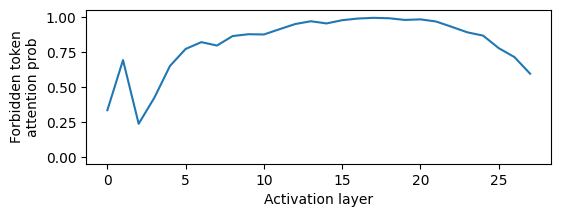

In [119]:
rot_q_final = cache["rot_q", LAYER][-1, HEAD]

resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
print("resid.shape", resid.shape)
assert resid.shape == (LAYER + 1, ld.pd.n_tokens, tl_model.cfg.d_model)
assert tl_model.b_K.abs().max() == 0

resid_norm = tl_model.blocks[LAYER].ln1(resid)
ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(ks)
rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")
f_rot_ks = rot_ks[:, fpos]

f_attn_scores = (f_rot_ks @ rot_q_final) / ATTN_SCALE
print("f_attn_logits.shape", f_attn_scores.shape)

ablt_attn_scores = einops.repeat(
    cache["attn_scores", LAYER][HEAD, -1],
    "pos -> layer pos",
    layer=len(f_attn_scores)
).clone()
ablt_attn_scores[:, fpos] = f_attn_scores

ablt_patterns = ablt_attn_scores.softmax(dim=-1)
print("ablt_patterns.shape", ablt_patterns.shape)

print(ablt_patterns[:, fpos][-1])
plt.figure(figsize=(6,2))
plt.plot(ablt_patterns[:, fpos].cpu().numpy())
plt.ylim(-0.05, 1.05)
plt.xlabel("Activation layer")
plt.ylabel("Forbidden token\nattention prob")
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     ablt_patterns, 
#     mask_upper_tri=False,
# )

### Last token query enrichment over layers -- attention effect

rot_ks.shape torch.Size([57, 128])
final_resid.shape torch.Size([28, 57, 4096])
qs.shape torch.Size([1, 57, 28, 128])
rot_qs.shape torch.Size([28, 57, 128])
final_rot_qs.shape torch.Size([28, 128])
attn.shape torch.Size([28, 57])
tensor(0.5931, device='cuda:0')


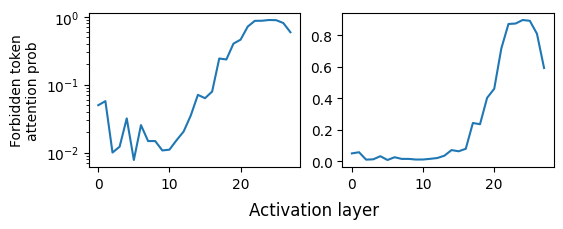

In [120]:
rot_ks = cache["rot_k", LAYER][:, HEAD]
print("rot_ks.shape", rot_ks.shape)

final_resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
print("final_resid.shape", final_resid.shape)

final_resid_norm = tl_model.blocks[LAYER].ln1(final_resid)
qs = final_resid_norm @ tl_model.W_Q[LAYER, HEAD]
qs = einops.rearrange(qs, "layer pos d -> 1 pos layer d")
print("qs.shape", qs.shape)

rot_qs = tl_model.blocks[LAYER].attn.apply_rotary(qs)
rot_qs = einops.rearrange(rot_qs, "1 pos layer d -> layer pos d")
print("rot_qs.shape", rot_qs.shape)

final_rot_qs = rot_qs[:, -1]
print("final_rot_qs.shape", final_rot_qs.shape)

logits = (final_rot_qs @ rot_ks.T) / ATTN_SCALE
attn = logits.softmax(dim=-1)
print("attn.shape", attn.shape)

print(attn[LAYER, fpos])

plt.figure(figsize=(6,2))

plt.subplot(1, 2, 1)
plt.plot(attn[:, fpos].cpu().numpy())
plt.yscale("log")
plt.ylabel("Forbidden token\nattention prob")

plt.subplot(1, 2, 2)
plt.plot(attn[:, fpos].cpu().numpy())

# supxlabel but shifted down
plt.gcf().supxlabel("Activation layer", y=-0.15)
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     attn, 
#     mask_upper_tri=False,
# )

### Query vec for football x Key vec for apple

In [124]:
fws: list[str] = ["Paris", "apple", "football", "tennis", "basketball"]

fw_pd_dict = {
    fw: prompt_data.PromptData.get_data(
        get_dontsay_prompt(question, fw),
        tl_model,
    )
    for fw in fws
}

for fw, pdata in fw_pd_dict.items():
    print(fw, pdata.ml_token, pdata.ml_str, len(pdata.tokens))

for fw1 in fws:
    for fw2 in fws:
        rot_ks1 = fw_pd_dict[fw1].cache["rot_k", LAYER][:, HEAD]
        rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

        scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
        attn = scores.softmax(dim=-1)

        print(f"keys: {fw1:<10}; query: {fw2:<10}; attn: {attn[fpos].item():.4f}")

Paris 20103 Nice 57
apple 3681 Paris 57
football 3681 Paris 57
tennis 3681 Paris 57
basketball 3681 Paris 57
keys: Paris     ; query: Paris     ; attn: 0.5931
keys: Paris     ; query: apple     ; attn: 0.6237
keys: Paris     ; query: football  ; attn: 0.4572
keys: Paris     ; query: tennis    ; attn: 0.6433
keys: Paris     ; query: basketball; attn: 0.6077
keys: apple     ; query: Paris     ; attn: 0.2869
keys: apple     ; query: apple     ; attn: 0.1048
keys: apple     ; query: football  ; attn: 0.0675
keys: apple     ; query: tennis    ; attn: 0.1369
keys: apple     ; query: basketball; attn: 0.1324
keys: football  ; query: Paris     ; attn: 0.2583
keys: football  ; query: apple     ; attn: 0.1278
keys: football  ; query: football  ; attn: 0.0553
keys: football  ; query: tennis    ; attn: 0.1565
keys: football  ; query: basketball; attn: 0.1291
keys: tennis    ; query: Paris     ; attn: 0.4404
keys: tennis    ; query: apple     ; attn: 0.1702
keys: tennis    ; query: football  ; attn

In [125]:
for fw1 in fws:
    for fw2 in fws:
        ks1 = fw_pd_dict[fw1].cache["k", LAYER][:, HEAD].clone()

        swap_pos = fpos
        tmp = ks1[fpos].clone()
        ks1[fpos] = ks1[swap_pos].clone()
        ks1[swap_pos] = tmp
        rot_ks1 = tl_model.blocks[LAYER].attn.apply_rotary(
            ks1[None, :, None, :]
        )[0, :, 0]

        rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

        scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
        attn = scores.softmax(dim=-1)

        print(
            f"keys: {fw1:<10}; query: {fw2:<10}; attn: {attn[swap_pos].item():.4f}"
        )

keys: Paris     ; query: Paris     ; attn: 0.5931
keys: Paris     ; query: apple     ; attn: 0.6237
keys: Paris     ; query: football  ; attn: 0.4572
keys: Paris     ; query: tennis    ; attn: 0.6433
keys: Paris     ; query: basketball; attn: 0.6077
keys: apple     ; query: Paris     ; attn: 0.2869
keys: apple     ; query: apple     ; attn: 0.1048
keys: apple     ; query: football  ; attn: 0.0675
keys: apple     ; query: tennis    ; attn: 0.1369
keys: apple     ; query: basketball; attn: 0.1324
keys: football  ; query: Paris     ; attn: 0.2583
keys: football  ; query: apple     ; attn: 0.1278
keys: football  ; query: football  ; attn: 0.0553
keys: football  ; query: tennis    ; attn: 0.1565
keys: football  ; query: basketball; attn: 0.1291
keys: tennis    ; query: Paris     ; attn: 0.4404
keys: tennis    ; query: apple     ; attn: 0.1702
keys: tennis    ; query: football  ; attn: 0.1352
keys: tennis    ; query: tennis    ; attn: 0.1660
keys: tennis    ; query: basketball; attn: 0.2100


resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.5931, device='cuda:0')


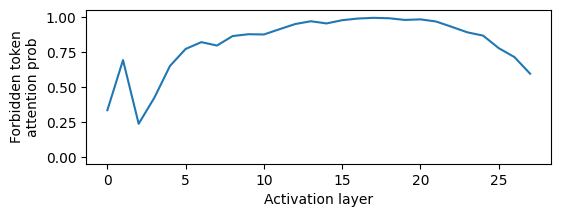

resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.7374, device='cuda:0')


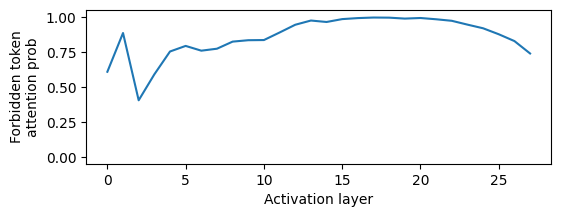

resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.4850, device='cuda:0')


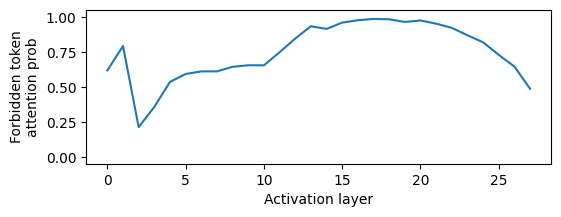

resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.7362, device='cuda:0')


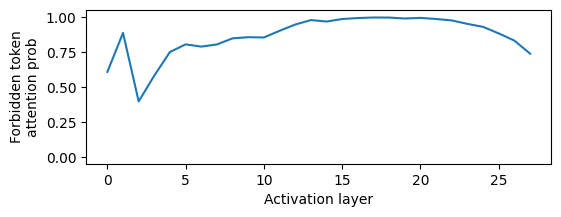

resid.shape torch.Size([28, 57, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 57])
tensor(0.6964, device='cuda:0')


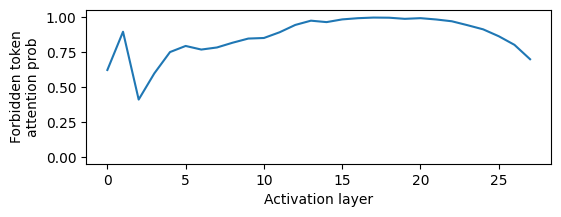

In [126]:
for fw2 in fws:
    rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

    resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
    print("resid.shape", resid.shape)
    assert resid.shape == (LAYER + 1, ld.pd.n_tokens, tl_model.cfg.d_model)
    assert tl_model.b_K.abs().max() == 0

    resid_norm = tl_model.blocks[LAYER].ln1(resid)
    ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
    ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
    rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(ks)
    rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")
    f_rot_ks = rot_ks[:, fpos]

    f_attn_scores = (f_rot_ks @ rot_q2) / ATTN_SCALE
    print("f_attn_logits.shape", f_attn_scores.shape)

    ablt_attn_scores = einops.repeat(
        cache["attn_scores", LAYER][HEAD, -1],
        "pos -> layer pos",
        layer=len(f_attn_scores)
    ).clone()
    ablt_attn_scores[:, fpos] = f_attn_scores

    ablt_patterns = ablt_attn_scores.softmax(dim=-1)
    print("ablt_patterns.shape", ablt_patterns.shape)

    print(ablt_patterns[:, fpos][-1])
    plt.figure(figsize=(6,2))
    plt.plot(ablt_patterns[:, fpos].cpu().numpy())
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Activation layer")
    plt.ylabel("Forbidden token\nattention prob")
    plt.show()

cv_attention.attention_pattern(
    ld.pd.token_strs,
    ablt_patterns, 
    mask_upper_tri=False,
)

### Last token query enrichment -- masking

In [ ]:
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

attn_del_q = torch.zeros_like(ld.pd.tokens).bool()
attn_del_q[-5:] = 1

# These tokens will not be attended to
attn_del_k = torch.zeros_like(ld.pd.tokens).bool()
attn_del_k[9:40] = 1
attn_del_k[41:43] = 1
attn_del_k[44:-5] = 1

display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_q.float(),
    )
)
display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_k.float(),
    )
)

attn_del_pattern = (attn_del_q[:, None] * attn_del_k[None, :]).float()
attn_del_pattern[-1, -5:-2] = 1
attn_del_pattern[-1, -1] = 1
attn_del_pattern[-2, -5] = 1
attn_del_pattern[-2, 40] = 1
attn_del_pattern[-3, -4] = 1
attn_del_pattern[-4, -4] = 1
attn_del_pattern[-5:-2, 40] = 1
attn_del_pattern[-3, 43] = 1
attn_del_pattern[-2, 43] = 1
attn_del_pattern[-5, 40] = 1

cv_attention.attention_pattern(
    tokens=ld.pd.token_strs,
    attention=attn_del_pattern,
)

In [ ]:
raw_logits = []
probs = []
for mask_limit in tqdm(range(LAYER + 2)):
    mtl_model = PerTokenMaskedTransformer(
        tl_model,
        base_prompt=ld.pd.prompt,
    )

    for i in range(mask_limit):
        mask = mtl_model.masks[f"{i}_attn_pattern"]
        mask[:] *= 1.0 - attn_del_pattern
    mtl_model.masks[f"{LAYER}_attn_pattern"][HEAD, -1, :] = 1

    _, mcache = mtl_model.tl_model.run_with_cache(
        ld.pd.prompt,
        remove_batch_dim=True,
        names_filter=[
            tl_utils.get_act_name("z", l) for l in range(tl_model.cfg.n_layers)
        ]
        + [
            tl_utils.get_act_name("attn", l)
            for l in range(tl_model.cfg.n_layers)
        ],
    )
    mcache.compute_head_results()

    logits = logit_lens.forward(mcache["result", LAYER][-1, HEAD], idx=LAYER)
    raw_logit = logits[ftok]
    raw_logits.append(raw_logit.item())

    prob = logits.softmax(dim=-1)[ftok]
    probs.append(prob.item())

tl_model.remove_all_hook_fns(including_permanent=True)

  0%|          | 0/28 [00:00<?, ?it/s]

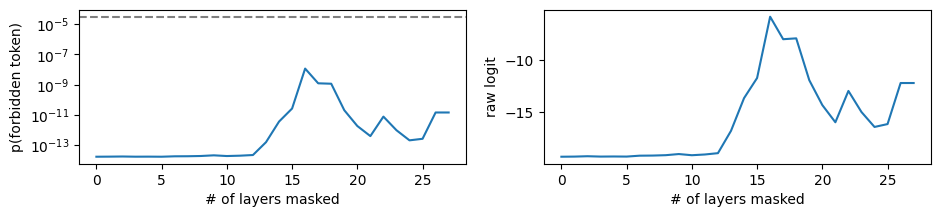

-12.211824417114258
L26H9 Attention Pattern:


In [ ]:
plt.figure(figsize=(11, 2))

plt.subplot(1, 2, 1)
plt.plot(probs)
plt.axhline(
    1 / hf_model.config.vocab_size,
    color="black",
    linestyle="--",
    alpha=0.5,
    zorder=-1,
)
plt.yscale("log")
plt.ylabel("p(forbidden token)")
plt.xlabel("# of layers masked")

plt.subplot(1, 2, 2)
plt.plot(raw_logits)
plt.ylabel("raw logit")
plt.xlabel("# of layers masked")
plt.show()

pattern = mcache["pattern", LAYER][HEAD]
print(raw_logits[-1])
print(f"{HEAD_STR} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)